In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from tqdm import tqdm
import gc
import math

In [11]:
font_list = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
person_info = pd.read_csv("../dataset/LPOINT_BIG_COMP_01_DEMO.csv", low_memory = False)
purchase_info = pd.read_csv("../dataset/LPOINT_BIG_COMP_02_PDDE.csv", low_memory = False)

In [12]:
# de_hr칼럼의 시간을 두 글자로 변경
purchase_info.loc[purchase_info['de_hr'] == 0, 'de_hr'] = '00'
purchase_info.loc[purchase_info['de_hr'] == 1, 'de_hr'] = '01'
purchase_info.loc[purchase_info['de_hr'] == 2, 'de_hr'] = '02'
purchase_info.loc[purchase_info['de_hr'] == 3, 'de_hr'] = '03'
purchase_info.loc[purchase_info['de_hr'] == 4, 'de_hr'] = '04'
purchase_info.loc[purchase_info['de_hr'] == 5, 'de_hr'] = '05'
purchase_info.loc[purchase_info['de_hr'] == 6, 'de_hr'] = '06'
purchase_info.loc[purchase_info['de_hr'] == 7, 'de_hr'] = '07'
purchase_info.loc[purchase_info['de_hr'] == 8, 'de_hr'] = '08'
purchase_info.loc[purchase_info['de_hr'] == 9, 'de_hr'] = '09'

In [13]:
purchase_info['de_dt'] = purchase_info['de_dt'].astype('str')
purchase_info['de_hr'] = purchase_info['de_hr'].astype('str')
purchase_info['time'] = purchase_info['de_dt'] + purchase_info['de_hr']

In [14]:
purchase_info['time'] = pd.to_datetime(purchase_info['time'].str.slice(start=0, stop=4) + "/" + 
                                       purchase_info['time'].str.slice(start=4, stop=6) + "/" +
                                       purchase_info['time'].str.slice(start=6, stop=8) + "/" + 
                                       purchase_info['time'].str.slice(start=8, stop=10) + ":0")

In [15]:
# person_info에 ma_fem_dv가 남성인 것만 추출
man_values = person_info.loc[person_info['ma_fem_dv'] == '남성']['cust'].values
man_purchase = purchase_info[purchase_info['cust'].isin(man_values)]

In [16]:
annual_purchase = man_purchase[['time','buy_ct']].groupby('time').sum()
annual_purchase.reset_index(inplace=True)

In [8]:
time_data = pd.date_range(start=annual_purchase.time.min(), end=annual_purchase.time.max(), freq='1H')
df_new = pd.merge(pd.DataFrame({'time': time_data}), annual_purchase, how='left', left_on='time', right_on='time').fillna(0).astype({'buy_ct': 'int64'})
df_new

,time,buy_ct
0,2021-01-01 00:00:00,23
1,2021-01-01 01:00:00,4
2,2021-01-01 02:00:00,7
3,2021-01-01 03:00:00,0
4,2021-01-01 04:00:00,8
...,...,...
8755,2021-12-31 19:00:00,488
8756,2021-12-31 20:00:00,461
8757,2021-12-31 21:00:00,355
8758,2021-12-31 22:00:00,225


In [19]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_new["buy_ct"] = min_max_scaler.fit_transform(df_new["buy_ct"].to_numpy().reshape(-1,1))

/media/sda1/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [20]:
train = df_new[:-744]
data_train = train["buy_ct"].to_numpy()

test = df_new[-744:]
data_test = test["buy_ct"].to_numpy()

In [23]:
print(data_train.shape)
print(data_test.shape)

(8016,)
(744,)


In [33]:
from torch.utils.data import DataLoader, Dataset
class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        # 첫번째 값은 input_window크기의 input data, 두번째 값은 output_window크기의 output_data 반환
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [34]:
# input window
iw = 1488
# output window
ow = 744

train_dataset = windowDataset(data_train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=16)

In [35]:
import torch
import torch.nn as nn
class TFModel(nn.Module):
    def __init__(self,iw, ow, d_model, nhead, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers) 
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        self.encoder = nn.Sequential(
            nn.Linear(1, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )
        
        self.linear =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(iw, (iw+ow)//2),
            nn.ReLU(),
            nn.Linear((iw+ow)//2, ow)
        ) 

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, srcmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src.transpose(0,1), srcmask).transpose(0,1)
        output = self.linear(output)[:,:,0]
        output = self.linear2(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [36]:
import gc
import math
device = torch.device("cuda:1")
lr = 1e-4
model = TFModel(1488, 744, 512, 8, 4, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
gc.collect()
torch.cuda.empty_cache()

In [37]:
from tqdm import tqdm
epoch = 200
model.train()
total_batch = len(train_loader)
loss_list = []
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    for (inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        result = model(inputs.float().to(device),  src_mask)
        loss = criterion(result, outputs[:,:,0].float().to(device))
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_loader)))
    avg_cost = batchloss / total_batch
    loss_list.append(avg_cost.detach().cpu().numpy())
    if i == epoch-1:
        torch.save(model.state_dict(), "./transformer.pth")

loss: 0.001473: 100%|██████████| 200/200 [5:12:25<00:00, 93.73s/it]   


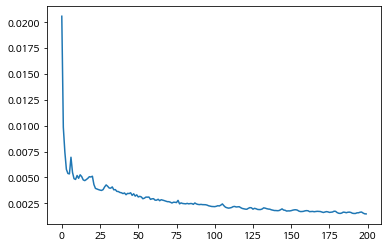

In [41]:
plt.plot(range(epoch),loss_list)

In [38]:
def evaluate():
    input = torch.tensor(data_train[-1488:]).reshape(1,-1,1).to(device).float().to(device)
    model.eval()
    
    src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
    predictions = model(input, src_mask)
    return predictions.detach().cpu().numpy()

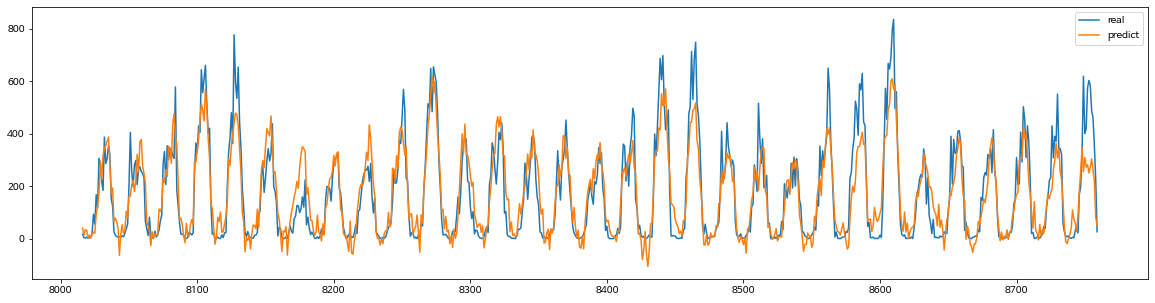

In [39]:
result = evaluate()
result = min_max_scaler.inverse_transform(result)[0]
real = df_new["buy_ct"].to_numpy()
real = min_max_scaler.inverse_transform(real.reshape(-1,1))[:,0]


plt.figure(figsize=(20,5))
plt.plot(range(8016,8760),real[8016:], label="real")
plt.plot(range(8760-744,8760),result, label="predict")
plt.legend()
plt.show()